## Adam convergence problem

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

We will solve the online optimization problem for function  $f_t(x) = \begin{cases} 1010x, \text{for t mod 101} = 1 \\ 
-10x, otherwise \end{cases}$

Online optimization task: $ F(x) = \sum_t f_t(x)  \to min_x$

with the constraint set $\mathcal{F} =[-1, 1]$

The analitical solution for this task is $x^*=-1$

In order to understand the problems of Adam, we denote the concept of "regret": $R_T = \sum\limits_{t=1}^T f_t(x_t) - \min\limits_{x \in \mathcal{F}} \sum\limits_{t=1}^T f_t(x)$

The regret should tend to zero during optimization, it implies that on average,
the model’s performance converges to the optimal one.

In [2]:
loss_buffer = []

In [3]:
import adashift.optimizers as ad_opt

In [4]:
def online_f_t(x, t):
    if t % 101 == 1:
        return 1010.0*x
    else:
        return -10.0*x
    
def f_min(t):
    if t % 101 == 1:
        return -1010.0
    else:
        return 10.0

In [5]:
def OnlineLearning(optimizer_type='Adam', start_lr=1, lr_decay=True, eps=0.,
                   x_init=0.0, betas=(0.9, 0.99), amsgrad=False, max_step = 1000001):
    x = torch.tensor([x_init], requires_grad=True)
    lr = start_lr
    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam([x], amsgrad=amsgrad, lr=lr, betas=betas, eps=eps)
    else:
        optimizer = ad_opt.AdaShift([x], lr=lr, betas=betas, eps=eps)
    
    
    regret_sum = 0
    time_steps = []
    avg_regret_history = []
    x_history = []
    
    if lr_decay:
        lambda_lr_decay = lambda step: start_lr / np.sqrt(step + 1) 
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr_decay)

    for step in range(1, max_step):
        # constraint
        x.data = x.data.clamp(-1, 1)
        
        loss = online_f_t(x, step)

        regret_sum += (loss.item() - f_min(step))
        regret_avg = regret_sum / step
    
        loss.backward()
        
        x_history.append(x.item())

        if step % 10000 == 0:
            time_steps.append(step)
            avg_regret_history.append(regret_avg)
        if step % 50000 == 0:
            print('step : {} loss: {} regret_avg : {} x: {}'.format(step, loss.item() , regret_avg, x.item()))

        optimizer.step()
                                
        if lr_decay:
            scheduler.step()
        optimizer.zero_grad()
                                                      
    return time_steps, avg_regret_history, x_history

In [6]:
time_steps, avg_regret_history, x_history = OnlineLearning()

step : 50000 loss: -9.889703750610352 regret_avg : 0.5064160437881574 x: 0.9889703989028931
step : 100000 loss: -9.864534378051758 regret_avg : 0.4067958796649985 x: 0.9864534735679626
step : 150000 loss: -9.865385055541992 regret_avg : 0.36496171242752423 x: 0.9865384697914124
step : 200000 loss: -9.87474250793457 regret_avg : 0.34069642169266007 x: 0.9874742031097412
step : 250000 loss: -9.886850357055664 regret_avg : 0.32442571966003625 x: 0.9886850118637085
step : 300000 loss: -9.899446487426758 regret_avg : 0.3125654876726804 x: 0.9899446368217468
step : 350000 loss: -9.911629676818848 regret_avg : 0.3034359073735933 x: 0.9911629557609558
step : 400000 loss: -9.92305850982666 regret_avg : 0.2961329248513235 x: 0.9923058152198792
step : 450000 loss: -9.933679580688477 regret_avg : 0.29012170080303734 x: 0.9933679699897766
step : 500000 loss: -9.943526268005371 regret_avg : 0.2850632473994456 x: 0.9943526387214661
step : 550000 loss: -9.952676773071289 regret_avg : 0.280731002208641

In [7]:
amsgrad_time_steps, amsgrad_avg_regret_history, amsgrad_x_history = OnlineLearning(amsgrad=True)

step : 50000 loss: 9.866371154785156 regret_avg : 0.31438381194114684 x: -0.9866371154785156
step : 100000 loss: 9.961386680603027 regret_avg : 0.21818181499004363 x: -0.9961386919021606
step : 150000 loss: 9.991243362426758 regret_avg : 0.17665848134676615 x: -0.9991243481636047
step : 200000 loss: 10.0 regret_avg : 0.1522245525431633 x: -1.0
step : 250000 loss: 9.999848365783691 regret_avg : 0.13568643005943298 x: -0.999984860420227
step : 300000 loss: 9.997462272644043 regret_avg : 0.12354937993208567 x: -0.9997462034225464
step : 350000 loss: 9.993610382080078 regret_avg : 0.11415799653870719 x: -0.9993610382080078
step : 400000 loss: 9.989237785339355 regret_avg : 0.10661422948002815 x: -0.9989237785339355
step : 450000 loss: 9.984785079956055 regret_avg : 0.10038345542165968 x: -0.9984785318374634
step : 500000 loss: 9.980443954467773 regret_avg : 0.09512501832294463 x: -0.9980443716049194
step : 550000 loss: 9.976297378540039 regret_avg : 0.09061027578093789 x: -0.99762970209121

In [8]:
adashift_time_steps, adashift_avg_regret_history, adashift_x_history = OnlineLearning(optimizer_type='Adashift') 

step : 50000 loss: -9.65464973449707 regret_avg : 0.5204434230518341 x: 0.9654649496078491
step : 100000 loss: -9.76864242553711 regret_avg : 0.4226181678247452 x: 0.976864218711853
step : 150000 loss: -9.821847915649414 regret_avg : 0.3800128746064504 x: 0.9821847677230835
step : 200000 loss: -9.85526180267334 regret_avg : 0.35483106342077253 x: 0.9855261445045471
step : 250000 loss: -9.879294395446777 regret_avg : 0.3377391733531952 x: 0.9879294037818909
step : 300000 loss: -9.898001670837402 regret_avg : 0.3251710242509842 x: 0.9898001551628113
step : 350000 loss: -9.913345336914062 regret_avg : 0.3154315921660832 x: 0.9913344979286194
step : 400000 loss: -9.926398277282715 regret_avg : 0.30759905756115913 x: 0.9926398396492004
step : 450000 loss: -9.93781566619873 regret_avg : 0.3011235512998369 x: 0.993781566619873
step : 500000 loss: -9.948019027709961 regret_avg : 0.2956541783056259 x: 0.994801938533783
step : 550000 loss: -9.95728874206543 regret_avg : 0.29095510620203885 x: 0.

Regret should tend to zero. As we can see it is done only for amsgrad.

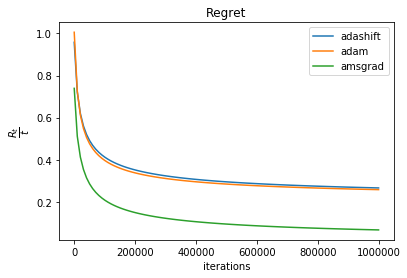

In [15]:
plt.title("Regret")
plt.plot(np.linspace(1, 1000001, 100), adashift_avg_regret_history, label='adashift')
plt.plot(np.linspace(1, 1000001, 100), avg_regret_history,label='adam')
plt.plot(np.linspace(1, 1000001, 100), amsgrad_avg_regret_history,label='amsgrad')
plt.xlabel("iterations")
plt.ylabel(r"$\dfrac{R_t}{t}$")
plt.legend()
plt.show()

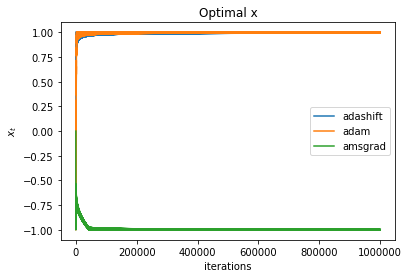

In [16]:
plt.title("Optimal x")
plt.plot(adashift_x_history, label='adashift')
plt.plot(x_history,label='adam')
plt.plot(amsgrad_x_history,label='amsgrad')
plt.legend()
plt.xlabel("iterations")
plt.ylabel(r"$x_t$")
plt.show()

Let's see on the similar task, but with stochasticity.

$\delta = 0.002$
C = 101

$f_t(x) = \begin{cases} Cx, \text{with p } =\frac{1+\delta}{C+1} \\ 
-x, otherwise \end{cases}$

Cost function is $\delta x$

In [ ]:
%reset

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from adashift.optimizers import AdaShift

In [2]:
delta = 0.02
C = 101
p = (1+delta)/(C + 1)

def stoch_f_t(x, t):
    if np.random.binomial(1,p):
        return C*x
    else:
        return -x

In [7]:
def StochLearning(optimizer_type='Adam', alpha=1e-3, lr_decay=True,\
                  amsgrad=False, max_step = 1000001, betas=(0.0, 0.999)):
    x = torch.tensor([0.0], requires_grad=True)
    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam([x], lr=alpha, betas=betas, eps=0, amsgrad=amsgrad)
    else:
        optimizer = AdaShift([x], lr=alpha, keep_num=1, betas=betas, eps=1e-10)

    time_steps = []
    avg_regret_history = []
    x_history = []
    loss_history = []
    print("Optimization with {}".format(optimizer_type))
    
    if lr_decay:
        lambda_lr_decay = lambda step: alpha / np.sqrt(step + 1) 
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr_decay)

    
    for step in range(1, max_step):
        #x.data = x.data.clamp(-1.0, 1.0)

        loss = stoch_f_t(x, step)

        loss.backward()
        x_history.append(x.item())
        loss_history.append(loss.item())
        time_steps.append(step)

        if step % 15000 == 0:
            print ('step : ',step, '  loss : ',loss.item(), ' x:', x.item() )
                                 
        optimizer.step()   

        if lr_decay:
            scheduler.step()
        
        optimizer.zero_grad()
            
    return time_steps, loss_history, x_history

In [14]:
lr = 1e-3
time_steps, loss_history, x_history = StochLearning(alpha=lr, lr_decay=False, max_step=5000000)

Optimization with Adam
step :  15000   loss :  0.0033377972431480885  x: -0.0033377972431480885
step :  30000   loss :  -0.13727842271327972  x: 0.13727842271327972
step :  45000   loss :  -0.4357605278491974  x: 0.4357605278491974
step :  60000   loss :  -0.4748813807964325  x: 0.4748813807964325
step :  75000   loss :  -0.4649693965911865  x: 0.4649693965911865
step :  90000   loss :  -0.44192594289779663  x: 0.44192594289779663
step :  105000   loss :  -0.30589741468429565  x: 0.30589741468429565
step :  120000   loss :  -0.3176212012767792  x: 0.3176212012767792
step :  135000   loss :  -0.11048397421836853  x: 0.11048397421836853
step :  150000   loss :  3.17987060546875  x: 0.03148386627435684
step :  165000   loss :  -0.18806442618370056  x: 0.18806442618370056
step :  180000   loss :  -0.21866261959075928  x: 0.21866261959075928
step :  195000   loss :  -0.19399414956569672  x: 0.19399414956569672
step :  210000   loss :  -0.12080768495798111  x: 0.12080768495798111
step :  225

step :  1815000   loss :  -3.8715336322784424  x: 3.8715336322784424
step :  1830000   loss :  -3.8715968132019043  x: 3.8715968132019043
step :  1845000   loss :  -4.122706413269043  x: 4.122706413269043
step :  1860000   loss :  -4.140988826751709  x: 4.140988826751709
step :  1875000   loss :  -4.171433448791504  x: 4.171433448791504
step :  1890000   loss :  -4.200245380401611  x: 4.200245380401611
step :  1905000   loss :  -4.4145588874816895  x: 4.4145588874816895
step :  1920000   loss :  -4.333791255950928  x: 4.333791255950928
step :  1935000   loss :  -4.433887481689453  x: 4.433887481689453
step :  1950000   loss :  -4.399937629699707  x: 4.399937629699707
step :  1965000   loss :  -4.3301262855529785  x: 4.3301262855529785
step :  1980000   loss :  -4.490201473236084  x: 4.490201473236084
step :  1995000   loss :  -4.458498954772949  x: 4.458498954772949
step :  2010000   loss :  -4.463711261749268  x: 4.463711261749268
step :  2025000   loss :  -4.657735347747803  x: 4.657

step :  3660000   loss :  -10.22032356262207  x: 10.22032356262207
step :  3675000   loss :  -10.291117668151855  x: 10.291117668151855
step :  3690000   loss :  1038.8338623046875  x: 10.285483360290527
step :  3705000   loss :  -10.471552848815918  x: 10.471552848815918
step :  3720000   loss :  -10.454272270202637  x: 10.454272270202637
step :  3735000   loss :  -10.336508750915527  x: 10.336508750915527
step :  3750000   loss :  -10.42416763305664  x: 10.42416763305664
step :  3765000   loss :  -10.494464874267578  x: 10.494464874267578
step :  3780000   loss :  -10.536272048950195  x: 10.536272048950195
step :  3795000   loss :  -10.484258651733398  x: 10.484258651733398
step :  3810000   loss :  -10.60352897644043  x: 10.60352897644043
step :  3825000   loss :  -10.803573608398438  x: 10.803573608398438
step :  3840000   loss :  -10.643428802490234  x: 10.643428802490234
step :  3855000   loss :  -10.728065490722656  x: 10.728065490722656
step :  3870000   loss :  -10.59200286865

In [8]:
adashift_time_steps, adashift_loss_history, adashift_x_history = \
                    StochLearning(optimizer_type='Adashift',lr_decay=False, max_step=5000000)

Optimization with Adashift
step :  15000   loss :  0.052233319729566574  x: -0.052233319729566574
step :  30000   loss :  0.1970198154449463  x: -0.1970198154449463
step :  45000   loss :  0.11089427769184113  x: -0.11089427769184113
step :  60000   loss :  0.10190469771623611  x: -0.10190469771623611
step :  75000   loss :  0.14206141233444214  x: -0.14206141233444214
step :  90000   loss :  -0.020626958459615707  x: 0.020626958459615707
step :  105000   loss :  0.21824778616428375  x: -0.21824778616428375
step :  120000   loss :  0.45227882266044617  x: -0.45227882266044617
step :  135000   loss :  0.5251982808113098  x: -0.5251982808113098
step :  150000   loss :  0.5006498694419861  x: -0.5006498694419861
step :  165000   loss :  0.37330520153045654  x: -0.37330520153045654
step :  180000   loss :  0.3538868725299835  x: -0.3538868725299835
step :  195000   loss :  0.3098051846027374  x: -0.3098051846027374
step :  210000   loss :  0.3687156140804291  x: -0.3687156140804291
step : 

step :  1815000   loss :  4.347588062286377  x: -4.347588062286377
step :  1830000   loss :  4.073554992675781  x: -4.073554992675781
step :  1845000   loss :  4.106132984161377  x: -4.106132984161377
step :  1860000   loss :  4.139411449432373  x: -4.139411449432373
step :  1875000   loss :  3.8258121013641357  x: -3.8258121013641357
step :  1890000   loss :  4.050742149353027  x: -4.050742149353027
step :  1905000   loss :  3.900768756866455  x: -3.900768756866455
step :  1920000   loss :  3.9275355339050293  x: -3.9275355339050293
step :  1935000   loss :  4.154553413391113  x: -4.154553413391113
step :  1950000   loss :  4.054102897644043  x: -4.054102897644043
step :  1965000   loss :  4.061435222625732  x: -4.061435222625732
step :  1980000   loss :  4.25602388381958  x: -4.25602388381958
step :  1995000   loss :  4.337325096130371  x: -4.337325096130371
step :  2010000   loss :  4.342714309692383  x: -4.342714309692383
step :  2025000   loss :  4.41455602645874  x: -4.4145560264

step :  3660000   loss :  5.305995941162109  x: -5.305995941162109
step :  3675000   loss :  5.309878826141357  x: -5.309878826141357
step :  3690000   loss :  5.450930595397949  x: -5.450930595397949
step :  3705000   loss :  5.267395496368408  x: -5.267395496368408
step :  3720000   loss :  5.1814985275268555  x: -5.1814985275268555
step :  3735000   loss :  5.414233684539795  x: -5.414233684539795
step :  3750000   loss :  5.450065612792969  x: -5.450065612792969
step :  3765000   loss :  5.216810703277588  x: -5.216810703277588
step :  3780000   loss :  4.972123622894287  x: -4.972123622894287
step :  3795000   loss :  5.106020927429199  x: -5.106020927429199
step :  3810000   loss :  5.231181621551514  x: -5.231181621551514
step :  3825000   loss :  5.283236980438232  x: -5.283236980438232
step :  3840000   loss :  5.241721153259277  x: -5.241721153259277
step :  3855000   loss :  5.3401103019714355  x: -5.3401103019714355
step :  3870000   loss :  5.274142742156982  x: -5.2741427

In [15]:
ams_time_steps, ams_loss_history, ams_x_history = StochLearning(alpha=lr, amsgrad=True, 
                                                                lr_decay=False, max_step=5000000)

Optimization with Adam
step :  15000   loss :  -0.2535580098628998  x: 0.2535580098628998
step :  30000   loss :  -0.22136470675468445  x: 0.22136470675468445
step :  45000   loss :  -0.2136051058769226  x: 0.2136051058769226
step :  60000   loss :  -0.1192018985748291  x: 0.1192018985748291
step :  75000   loss :  -0.1908951997756958  x: 0.1908951997756958
step :  90000   loss :  -0.08858227729797363  x: 0.08858227729797363
step :  105000   loss :  0.1718059480190277  x: -0.1718059480190277
step :  120000   loss :  0.30342134833335876  x: -0.30342134833335876
step :  135000   loss :  0.2749955952167511  x: -0.2749955952167511
step :  150000   loss :  0.3230714499950409  x: -0.3230714499950409
step :  165000   loss :  0.34332212805747986  x: -0.34332212805747986
step :  180000   loss :  0.34966525435447693  x: -0.34966525435447693
step :  195000   loss :  0.42554613947868347  x: -0.42554613947868347
step :  210000   loss :  0.37625905871391296  x: -0.37625905871391296
step :  225000   

step :  1815000   loss :  2.9336769580841064  x: -2.9336769580841064
step :  1830000   loss :  2.9400112628936768  x: -2.9400112628936768
step :  1845000   loss :  2.8768084049224854  x: -2.8768084049224854
step :  1860000   loss :  3.0013558864593506  x: -3.0013558864593506
step :  1875000   loss :  3.1954405307769775  x: -3.1954405307769775
step :  1890000   loss :  3.201774835586548  x: -3.201774835586548
step :  1905000   loss :  3.2637388706207275  x: -3.2637388706207275
step :  1920000   loss :  3.471730947494507  x: -3.471730947494507
step :  1935000   loss :  3.3389909267425537  x: -3.3389909267425537
step :  1950000   loss :  3.2896955013275146  x: -3.2896955013275146
step :  1965000   loss :  3.4907338619232178  x: -3.4907338619232178
step :  1980000   loss :  3.4414384365081787  x: -3.4414384365081787
step :  1995000   loss :  3.5938007831573486  x: -3.5938007831573486
step :  2010000   loss :  3.523644208908081  x: -3.523644208908081
step :  2025000   loss :  3.606469392776

step :  3645000   loss :  6.251522541046143  x: -6.251522541046143
step :  3660000   loss :  6.15355110168457  x: -6.15355110168457
step :  3675000   loss :  6.333728313446045  x: -6.333728313446045
step :  3690000   loss :  6.256618022918701  x: -6.256618022918701
step :  3705000   loss :  6.276859760284424  x: -6.276859760284424
step :  3720000   loss :  6.2553791999816895  x: -6.2553791999816895
step :  3735000   loss :  6.296482086181641  x: -6.296482086181641
step :  3750000   loss :  6.316723823547363  x: -6.316723823547363
step :  3765000   loss :  6.295243263244629  x: -6.295243263244629
step :  3780000   loss :  6.524096488952637  x: -6.524096488952637
step :  3795000   loss :  6.460893630981445  x: -6.460893630981445
step :  3810000   loss :  6.536765098571777  x: -6.536765098571777
step :  3825000   loss :  6.598729133605957  x: -6.598729133605957
step :  3840000   loss :  6.716322898864746  x: -6.716322898864746
step :  3855000   loss :  6.931268692016602  x: -6.93126869201

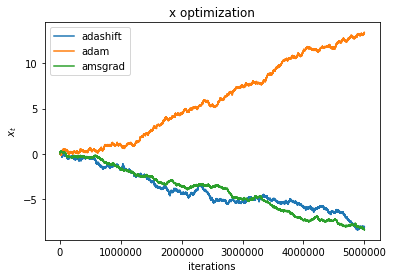

In [16]:
plt.title("x optimization")
plt.plot(adashift_x_history, label='adashift')
plt.plot(x_history,label='adam')
plt.plot(ams_x_history, label='amsgrad')
plt.legend()
plt.xlabel("iterations")
plt.ylabel(r"$x_t$")
plt.show()

#### Logistic regression on MNIST

In [35]:
import torchvision
import torchvision.transforms as transforms

input_size = 784
num_classes = 10
num_epochs = 5
batch_size = 128
learning_rate = 0.001

train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Processing...
Done!


In [41]:
import torch.nn as nn

model = nn.Linear(input_size, num_classes)

criterion = nn.CrossEntropyLoss()

adam_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,\
                             betas=(0.9, 0.99), eps=1e-8, weight_decay=0)

In [43]:
def train_model(model,criterion, optimizer):
    total_step = len(train_loader)
    loss_hist = []

    for epoch in range(num_epochs):
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28*28)
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss_hist.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, batch_idx+1, total_step, loss.item()))
    return loss_hist

In [44]:
adam_loss_hist = train_model(model, criterion, adam_optimizer)

Epoch [1/5], Step [1/469], Loss: 2.2687
Epoch [1/5], Step [101/469], Loss: 0.7454
Epoch [1/5], Step [201/469], Loss: 0.6171
Epoch [1/5], Step [301/469], Loss: 0.5432
Epoch [1/5], Step [401/469], Loss: 0.3711
Epoch [2/5], Step [1/469], Loss: 0.5302
Epoch [2/5], Step [101/469], Loss: 0.3812
Epoch [2/5], Step [201/469], Loss: 0.3336
Epoch [2/5], Step [301/469], Loss: 0.4105
Epoch [2/5], Step [401/469], Loss: 0.3198
Epoch [3/5], Step [1/469], Loss: 0.2538
Epoch [3/5], Step [101/469], Loss: 0.2966
Epoch [3/5], Step [201/469], Loss: 0.2887
Epoch [3/5], Step [301/469], Loss: 0.2321
Epoch [3/5], Step [401/469], Loss: 0.2651
Epoch [4/5], Step [1/469], Loss: 0.1812
Epoch [4/5], Step [101/469], Loss: 0.2903
Epoch [4/5], Step [201/469], Loss: 0.3682
Epoch [4/5], Step [301/469], Loss: 0.1999
Epoch [4/5], Step [401/469], Loss: 0.2982
Epoch [5/5], Step [1/469], Loss: 0.2515
Epoch [5/5], Step [101/469], Loss: 0.1594
Epoch [5/5], Step [201/469], Loss: 0.3477
Epoch [5/5], Step [301/469], Loss: 0.2385
Ep

In [46]:
model = nn.Linear(input_size, num_classes)

criterion = nn.CrossEntropyLoss()

amsgrad_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,\
                             betas=(0.9, 0.99), eps=1e-8, weight_decay=0,amsgrad=True)

ams_loss_hist = train_model(model, criterion, amsgrad_optimizer)

Epoch [1/5], Step [1/469], Loss: 2.3129
Epoch [1/5], Step [101/469], Loss: 0.7497
Epoch [1/5], Step [201/469], Loss: 0.5527
Epoch [1/5], Step [301/469], Loss: 0.3873
Epoch [1/5], Step [401/469], Loss: 0.3741
Epoch [2/5], Step [1/469], Loss: 0.3965
Epoch [2/5], Step [101/469], Loss: 0.3368
Epoch [2/5], Step [201/469], Loss: 0.3231
Epoch [2/5], Step [301/469], Loss: 0.3286
Epoch [2/5], Step [401/469], Loss: 0.2998
Epoch [3/5], Step [1/469], Loss: 0.2921
Epoch [3/5], Step [101/469], Loss: 0.3372
Epoch [3/5], Step [201/469], Loss: 0.3200
Epoch [3/5], Step [301/469], Loss: 0.2950
Epoch [3/5], Step [401/469], Loss: 0.3556
Epoch [4/5], Step [1/469], Loss: 0.2234
Epoch [4/5], Step [101/469], Loss: 0.3888
Epoch [4/5], Step [201/469], Loss: 0.2573
Epoch [4/5], Step [301/469], Loss: 0.2937
Epoch [4/5], Step [401/469], Loss: 0.2395
Epoch [5/5], Step [1/469], Loss: 0.2106
Epoch [5/5], Step [101/469], Loss: 0.2355
Epoch [5/5], Step [201/469], Loss: 0.3712
Epoch [5/5], Step [301/469], Loss: 0.3334
Ep

In [49]:
model = nn.Linear(input_size, num_classes)

criterion = nn.CrossEntropyLoss()

adashift_optimizer = ad_opt.AdaShift(model.parameters(), lr=1e-3,\
                             betas=(0.0, 0.99), eps=1e-8)

adashift_loss_hist = train_model(model, criterion, adashift_optimizer)

Epoch [1/5], Step [1/469], Loss: 2.3321
Epoch [1/5], Step [101/469], Loss: 1.4465
Epoch [1/5], Step [201/469], Loss: 1.0807
Epoch [1/5], Step [301/469], Loss: 0.8524
Epoch [1/5], Step [401/469], Loss: 0.7565
Epoch [2/5], Step [1/469], Loss: 0.6515
Epoch [2/5], Step [101/469], Loss: 0.5573
Epoch [2/5], Step [201/469], Loss: 0.5489
Epoch [2/5], Step [301/469], Loss: 0.6696
Epoch [2/5], Step [401/469], Loss: 0.6332
Epoch [3/5], Step [1/469], Loss: 0.3607
Epoch [3/5], Step [101/469], Loss: 0.5934
Epoch [3/5], Step [201/469], Loss: 0.3756
Epoch [3/5], Step [301/469], Loss: 0.4932
Epoch [3/5], Step [401/469], Loss: 0.4231
Epoch [4/5], Step [1/469], Loss: 0.3594
Epoch [4/5], Step [101/469], Loss: 0.3689
Epoch [4/5], Step [201/469], Loss: 0.4349
Epoch [4/5], Step [301/469], Loss: 0.3094
Epoch [4/5], Step [401/469], Loss: 0.4228
Epoch [5/5], Step [1/469], Loss: 0.3735
Epoch [5/5], Step [101/469], Loss: 0.3209
Epoch [5/5], Step [201/469], Loss: 0.3687
Epoch [5/5], Step [301/469], Loss: 0.2852
Ep

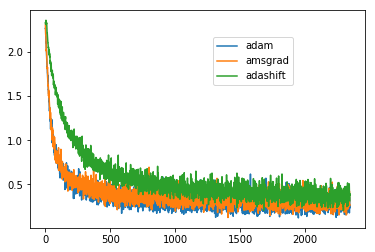

In [52]:
plt.plot(adam_loss_hist, label="adam")
plt.plot(ams_loss_hist, label="amsgrad")
plt.plot(adashift_loss_hist, label="adashift")

plt.legend(bbox_to_anchor=(0.8, 0.9), loc='best')
plt.show()